In [ ]:
import time

class TrackingEnvironment:
    def __init__(self):
        self.x=0        
        self.turn_action=0
        self.turn_time_steps=0
        self.vx_magnitude=0.1
        ...
        self.position_uncertainty=0.005
        self.velocity_uncertianty=0.001
        
        self.obs_size=2
        self.action_size=1
        
    def step(self,action):
        #action is [turn_magnitude]
        #response is [x,accel_x]
        if action[0]!=0:
            action[0]=np.clip(action[0],-1,1)
            self.turn_action=np.sign(action[0])
            self.turn_time_steps=5*np.abs(action[0])        
        if self.turn_time_steps>0:
            vx=self.vx_magnitude*self.turn_action
        else:
            vx=0
        self.x+=vx
        self.turn_time_steps-=1
        return [self.x+np.random.normal(0,self.position_uncertainty),vx+np.random.normal(0,self.velocity_uncertianty)]
        
target_names=["position","velocity"]

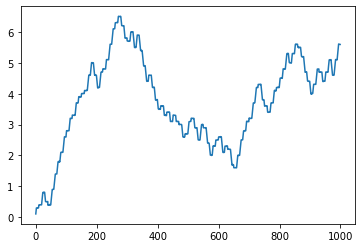

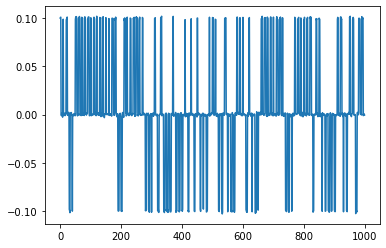

In [2]:
from matplotlib import pyplot as plt
import random
import numpy as np

env=TrackingEnvironment()
obs_record=[]
input_record=[]
obs=env.step([0])
for i in range(1000):
    if i%10==0:
        action=random.uniform(-1,1)
    else:
        action=0
    input_record.append(np.concatenate( (obs,np.array([action])) ))
    obs=env.step([action])
    obs_record.append(obs)
    
obs_record=np.array(obs_record)
fig, ax = plt.subplots()
ax.plot(obs_record[:,0])
plt.show()
fig, ax = plt.subplots()
ax.plot(obs_record[:,1])
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm import tqdm

class SimulatorLSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        #input size is features_size+control_size
        #output_size is features_size
        super(SimulatorLSTM, self).__init__()        
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_size=hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True) #number of hidden nodes same as input
        self.combiner=nn.Linear(input_size+hidden_size,output_size)
        
    def multi_prediction(self,input_x_array_batched,hc_start):
        #input_x_array_batched, a concatenated array of (state,control) of shape [n_batch,n_seq,features_size+control_size]
        hidden_array_batched,last_hcout_array_batched=self.lstm(input_x_array_batched,hc_start)        
        input_and_hidden_merged_batched=torch.cat((input_x_array_batched,hidden_array_batched),2)
        prediction_batched=self.combiner(input_and_hidden_merged_batched)
        return prediction_batched,last_hcout_array_batched        
        
    def single_prediction(self,state_x,control_x,hc ):
        #inputs
        # state_x -> vector indicating system state
        # control_x -> vector indicating control input
        # hc ->   (hidden_state, c_from_lstm)
        input_x_array_batched=torch.unsqueeze(torch.unsqueeze(torch.cat(state_x,control_x),0),0) # turn it into [batch, sequence, value]
        hc_array_batched=torch.unsqueeze(torch.unsqueeze(hc))        
        prediction_batched,last_hcout_array_batched=self.multi_prediction(input_x_array,hc_array_batched)
        return prediction_batched[0][0],last_hcout_array_batched[0][0]
    
    def forward(self,x,hc_start=None):
        return self.multi_prediction(x,hc_start)
    
class SimulatorLinear(nn.Module):
    def __init__(self,input_size,output_size):
        #input size is features_size+control_size
        #output_size is features_size
        super(SimulatorLinear, self).__init__()        
        self.nn=nn.Linear(input_size,output_size)
        
        
    def multi_prediction(self,input_x_array_batched,hc_start):
        #input_x_array_batched, a concatenated array of (state,control) of shape [n_batch,n_seq,features_size+control_size]
        return self.nn(input_x_array),None        
        
    def single_prediction(self,state_x,control_x,hc ):
        #inputs
        # state_x -> vector indicating system state
        # control_x -> vector indicating control input
        # hc ->   (hidden_state, c_from_lstm)        
        input_x_array_batched=torch.unsqueeze(torch.unsqueeze(torch.cat(state_x,control_x),0),0) # turn it into [batch, sequence, value]
        hc_array_batched=None
        prediction_batched,last_hcout_array_batched=self.multi_prediction(input_x_array,hc_array_batched)
        return prediction_batched[0][0],None
    
    def forward(self,x,hc_start=None):
        return self.nn(x),None        

In [4]:
print("Input and Obs {} vs {}".format(len(input_record[0]),len(obs_record[0])))
#lstmmodel=MyLSTM(len(input_record[0]),len(obs_record[0]))
lstmmodel=SimulatorLSTM(len(input_record[0]),len(obs_record[0]),len(input_record[0]))
#lstmmodel=SimulatorLinear(len(input_record[0]),len(obs_record[0]))


Input and Obs 3 vs 2


In [5]:
input_record=torch.tensor(input_record).float()
obs_record=torch.tensor(obs_record).float()

def sample_input(n):
    trainset_input=[]
    trainset_output=[]
    input_length=20
    for i in range(n):
        start_val=random.randrange(0,len(input_record)-input_length)
        
        trainset_input.append(input_record[start_val:start_val+input_length])
        trainset_output.append(obs_record[start_val:start_val+input_length])
    return torch.stack(trainset_input),torch.stack(trainset_output)
        
input_seqs,output_seqs=sample_input(20)


optimizer = optim.Adam(lstmmodel.parameters(), lr=0.001)


loss_function = torch.nn.MSELoss()
loss_record=[]
for epoch in tqdm(range(4000)):
    #for epoch in tqdm(range(10)):
    out,_=lstmmodel(input_seqs)
    loss=loss_function(out,output_seqs)
    loss_record.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 277.15it/s]


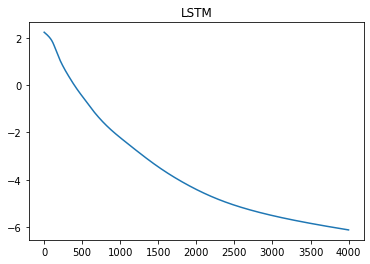

In [6]:
fig, ax = plt.subplots()
plt.title("LSTM")
ax.plot(np.log(loss_record))
plt.show()

In [32]:
model_seqs,_=lstmmodel(torch.unsqueeze(input_record,0))
print(model_seqs.shape)

for i in range(model_seqs.shape[2]):
    fig, ax = plt.subplots()
    plt.title("{} - {}".format("title",target_names[i]))
    plt.xlim(400,500)
    ax.plot(input_record[:,i])
        #ax.plot(target_vector_record[:,i])

    ax.plot(model_seqs[0,:,i].detach().numpy(),'*')
        
    plt.show()


TypeError: unsqueeze(): argument 'input' (position 1) must be Tensor, not list

In [8]:
#so I've got a model of the system, now I need to train a controller

#Desired Value ->  Control Network -> SimulatorLSTM -> Sim Result
#                                  |-> Real System -> Real Result
#
#  Error signal = Real Result - Desired Value
#  How do I convince Pytorch to backpropagate using real result instead of sim result? (note if sim is good enough, then I don't need the real system.  Train on it like sleep)
#  Internet says 'data' is the value to modify

#things I want to do with this

#1) Feed in experiences and train the simulator ignoring the control network

#2) Feed in experiences and train the control network

#3) Step by step letting the control network make a choice




In [9]:
class ControlNetworkRealSimple(nn.Module):
    def __init__(self,obs_size,target_size,hidden_size,controls_size):
        super(ControlNetworkRealSimple, self).__init__()
        
        self.mynn=nn.Sequential(nn.Linear(2,1,bias=False),
                                nn.Tanh())

    def single_prediction(self,x,target):
        #print("xshape {}".format(x.shape))

        #x -> observed state
        #target -> some sort of desired value vector
        #the relevant criteria is that one target maps to one way the error computer works
        input_vector=torch.unsqueeze(torch.cat( (x,target),0),0)
        
        output_vector=self.forward(torch.unsqueeze(input_vector,0))[0][0]
        return output_vector
        
    def forward(self,x):
        #x concatenation of (observed state, desired value)
        #print("xshape {}".format(x.shape))
        inp=x[:,:,0:3:2]
        return self.mynn(inp)
        

class ControlNetworkSimple(nn.Module):
    def __init__(self,obs_size,target_size,hidden_size,controls_size):
        super(ControlNetworkSimple, self).__init__()
        
        self.mynn=nn.Sequential( nn.Linear(obs_size+target_size,hidden_size),
                       nn.ReLU(),
                       nn.Linear(hidden_size,controls_size) )
        
    def single_prediction(self,x,target):
        #x -> observed state
        #target -> some sort of desired value vector
        #the relevant criteria is that one target maps to one way the error computer works
        input_vector=torch.unsqueeze(torch.cat( (x,target),0),0)
        output_vector=self.mynn(input_vector)[0]
        return output_vector
        
    def forward(self,x):
        #x concatenation of (observed state, desired value)
        return self.mynn(x)        
        
class ErrorComputer(): #if you're careful, you can just do this with a loss function
    def __init__(self):
        ...
        
    def comput_error(target,observed):
        ...

n training chunks: 198


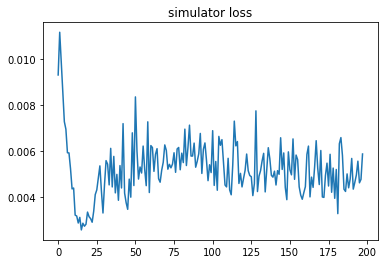

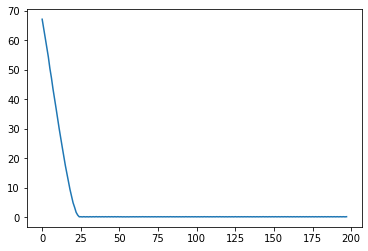

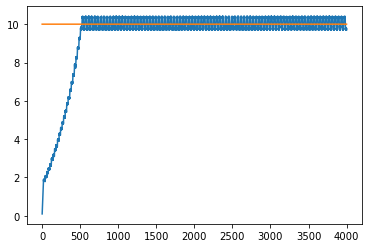

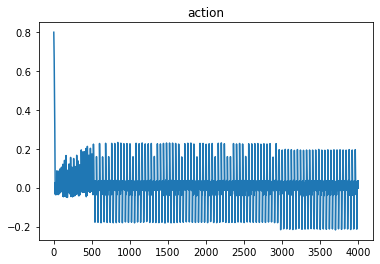

In [31]:
def train_simulator(training_chunks,simulator):
    
    inpus=[]
    onpus=[]
    #always include most recent chunk
    inpus.append(torch.tensor(training_chunks[-1]["input_vectors"]).float())
    onpus.append(torch.tensor(training_chunks[-1]["observation_vectors"]).float())
    #and 9 more random chunks
    for i in range(9):
        n=random.randrange(len(training_chunks))
        inpus.append(torch.tensor(training_chunks[n]["input_vectors"]).float())
        onpus.append(torch.tensor(training_chunks[n]["observation_vectors"]).float())
    
    
#    obs_input=torch.unsqueeze(torch.tensor(training_chunk["input_vectors"]),0).float()
#    observation_output=torch.unsqueeze(torch.tensor(training_chunk["observation_vectors"]),0).float()
    
    obs_input=torch.stack( inpus,0)
    observation_output=torch.stack( onpus,0)
    for p in simulator.parameters():
        p.requires_grad=True
    optimizer = optim.Adam(simulator.parameters(), lr=0.001)
    loss_function = torch.nn.MSELoss()
    #print("obs input shape {}".format(obs_input.shape))

    sim_output,_=simulator(obs_input)
    #print("sim output shape {}".format(sim_output.shape))
    #print("observation output shape {}".format(observation_output.shape))
    loss=loss_function(sim_output,observation_output)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_controls(training_chunk,control,simulator):
    obs_input=torch.unsqueeze(torch.tensor(training_chunk["prev_obs"]),0).float()
    target_input=torch.unsqueeze(torch.tensor(training_chunk["target_vectors"]),0).float()
    observation_output=torch.unsqueeze(torch.tensor(training_chunk["observation_vectors"]),0).float()
    
    
    
    for p in simulator.parameters():
        p.requires_grad=False
    optimizer = optim.Adam(control.parameters(), lr=0.01)
    loss_function = torch.nn.MSELoss()
      
    #print("obs input shape {}".format(obs_input.shape))
    #print("target input shape {}".format(target_input.shape))
    control_input=torch.cat((obs_input,target_input),2)
    
    control_output=control(control_input)
    #print("control_output shape {}".format(control_output.shape))
    #print("control output {}".format(control_output))
    
    sim_input_vectors=torch.cat((obs_input,control_output),2)
    
    #print("Elem 1: Obsevered state: {}".format(sim_input_vectors[0][0]))
    
    #print("sim input vectors sahpe {}".format(sim_input_vectors.shape))
    sim_output,_=simulator(sim_input_vectors)
    
    #print("Elem 1: Predicted next state: {}".format(sim_output[0][0]))
    #print("Elem 1: Actual next state: {}".format(observation_output[0][0]))
    
    # A*[0]+B*Target= Control is input, and motion is in direction of control
    # So loss is (Oldvalue+A*Oldvalue*dt+B*Target*dt-Target)^2    
    
    
    #print("sim output vectors shape {}".format(sim_output.shape))
    
    #print("sim output {}".format(sim_output[:,:,0:1]))
    #print("sim output {}".format(sim_output[0,:,:]))
    #Here is where I should put in the real values
    #or i in range(sim_output.shape[1]):
#        for j in range(sim_output.shape[2]):
#            sim_output[0][i][j].data=observation_output[0][i][j].data
    #sim_output.data=observation_output.data
     
    sim_output_target=sim_output[:,:,0:1]
    #print("observation output {}".format(observation_output))
    #print("sim output target {}".format(sim_output_target))
    #print("target input {}".format(target_input))
    #print("sim output target shape {}".format(sim_output_target.shape))
    #print("target input shape {}".format(target_input.shape))
    #print("real output {}".format(sim_output[:,:,0]))
    #print("target output {}".format(target_input))
    #TODO here is where I should have more general loss    
    loss=loss_function(sim_output_target,target_input)
        
    optimizer.zero_grad()
    loss.backward()
    
    
    #count=0
    #for p in control.parameters():
    #    print("Parameter {} = {} with grad {}".format(count,p,p.grad))
    #    count+=1
    
    optimizer.step()
    return loss.item()


env=TrackingEnvironment()
target_size=1

simulator=lstmmodel
#control=ControlNetworkSimple(env.obs_size, target_size,env.obs_size,env.action_size)
control=ControlNetworkRealSimple(env.obs_size, target_size,env.obs_size,env.action_size)



target_value=10

nsteps=4000
train_chunk_size=20
training_chunks=[]  # this is an array of    [ input_vectors, target_vectors, subsequent_output_vectors ]


obs_record=[]
input_record=[]
target_record=[]
obs=env.step([0])
controls_loss_record=[]
simulator_loss_record=[]
action_record=[]
for i in range(nsteps):
    #action=0
    #print("Observing: {}".format(obs))
    action_tensor=control.single_prediction(torch.tensor(obs).float(),torch.tensor([target_value]).float())    
    action=action_tensor.detach()[0].item()
    #print("acting {}".format(action))
    action_record.append(action)


    
    input_record.append(np.concatenate( (obs,np.array([action])) ))
    obs=env.step([action])
    obs_record.append(obs)
    target_record.append([target_value])
    
    if i%train_chunk_size==0 and i>train_chunk_size:
        new_chunk={"prev_obs": obs_record[-train_chunk_size-1:-1],
                   "input_vectors": input_record[-train_chunk_size:],
                   "target_vectors": target_record[-train_chunk_size:],
                   "observation_vectors": obs_record[-train_chunk_size:]}
        
        training_chunks.append(new_chunk)
        #TODO train environment model
        #TODO train controls
        simulator_loss_record.append(train_simulator(training_chunks,simulator))
        controls_loss_record.append(train_controls(new_chunk,control,simulator))
        
    
print("n training chunks: {}".format(len(training_chunks)))
    
obs_record=np.array(obs_record)

fig, ax = plt.subplots()
plt.title("simulator loss")
ax.plot(simulator_loss_record)
plt.show()

fig, ax = plt.subplots()
ax.plot(controls_loss_record)
plt.show()

fig, ax = plt.subplots()
ax.plot(obs_record[:,0])
ax.plot(target_record)
plt.show()

fig, ax = plt.subplots()
plt.title("action")
ax.plot(action_record)
plt.show()
